<a href="https://colab.research.google.com/github/jrgosalvez/data255_DL/blob/main/Jorge_Gosalvez_255_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SJSU MSDS 255 DL, Spring 2024
Homework 05: GAN

Git: https://github.com/jrgosalvez/data255_DL

# Part 1 -  GAN

### Step 1. Load Fashion MNIST & Replace Dataset in Demo

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])

#transform = transforms.Compose([transforms.ToTensor(),
#  transforms.Normalize((0.5,), (0.5,))
#])

train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transform, download=False)

In [3]:
img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[0.0000, 0.0000, 0.0000, 0.7569, 0.8941],
         [0.0118, 0.0000, 0.0471, 0.8588, 0.8627],
         [0.0235, 0.0000, 0.3882, 0.9569, 0.8706],
         [0.0000, 0.0000, 0.2157, 0.9255, 0.8941],
         [0.0000, 0.0000, 0.9294, 0.8863, 0.8510]]])


(tensor(0.), tensor(1.))

In [4]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0,1)

Label: 9


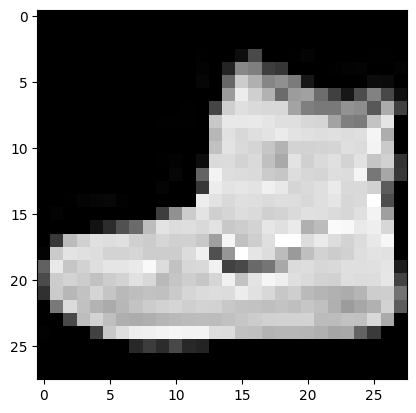

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

#### Download in batches

In [6]:
batch_size = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 6, 6, 1, 4, 9, 2, 8, 0, 3, 7, 8, 4, 2, 7, 1, 0, 9, 9, 5, 8, 9, 4, 0,
        2, 3, 4, 7, 7, 3, 8, 1, 1, 9, 3, 7, 9, 8, 5, 4, 3, 7, 4, 3, 7, 8, 3, 0,
        4, 3, 1, 7, 9, 4, 0, 2, 6, 9, 4, 9, 3, 7, 7, 9, 8, 4, 8, 4, 5, 8, 2, 1,
        7, 8, 5, 4, 5, 9, 9, 5, 1, 9, 2, 9, 7, 6, 3, 9, 5, 9, 2, 7, 5, 6, 3, 1,
        3, 8, 1, 9])


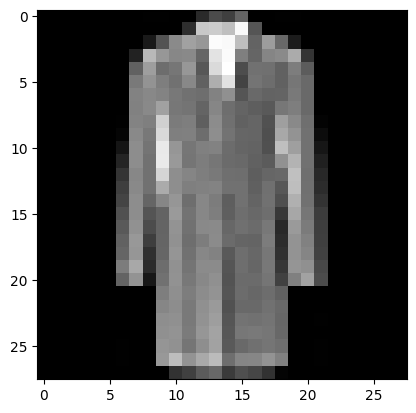

In [7]:
for img_batch, label_batch in train_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

### Step 2. Train GAN to produce images

In [8]:
image_size  = 784
hidden_size = 256
latent_size = 64

In [9]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

#### Instantiate the generator and generage random fake images

In [11]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

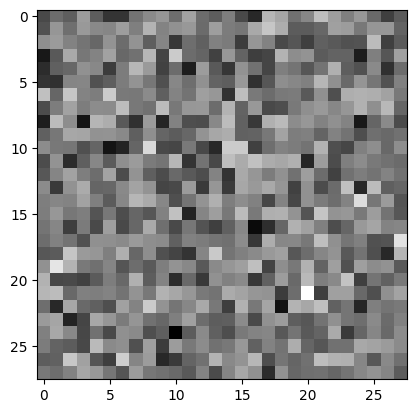

In [12]:
plt.imshow(gen_imgs[0], cmap='gray');

#### Build the network and move generator and discriminator to the device

In [13]:
D.to(device);

In [14]:
G.to(device);

In [15]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [16]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [17]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [18]:
def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

def D_train(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    D_optimizer.step()

    return d_loss, real_score, fake_score

In [19]:
def G_train():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    G_optimizer.step()
    return g_loss, fake_images

## Train the model

#### Create and save intermediate outputs from the generator for visual inspection later

In [20]:
import os

sample_dir = 'sample_data'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

#### Batch of real training images

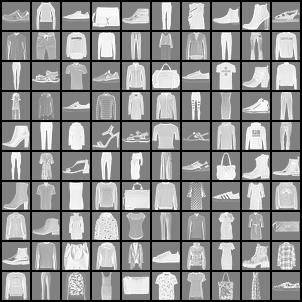

In [21]:
from IPython.display import Image

# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

#### Helper function to save batch of generated images at end of ea epoch to see evolution over time

Saving fake_images-0000.png


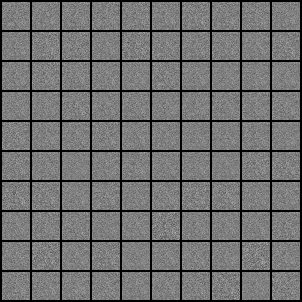

In [22]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

#### Train Model

In [23]:
%%time

num_epochs = 300
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0899, g_loss: 4.3959, D(x): 0.96, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.2149, g_loss: 5.8951, D(x): 0.90, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.1693, g_loss: 4.2356, D(x): 0.92, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.2010, g_loss: 3.4154, D(x): 0.92, D(G(z)): 0.09
Epoch [1/300], Step [400/600], d_loss: 0.4308, g_loss: 2.9578, D(x): 0.85, D(G(z)): 0.12
Epoch [1/300], Step [600/600], d_loss: 0.3155, g_loss: 3.7022, D(x): 0.89, D(G(z)): 0.14
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8614, g_loss: 1.9833, D(x): 0.73, D(G(z)): 0.27
Epoch [2/300], Step [400/600], d_loss: 0.8980, g_loss: 3.6903, D(x): 0.67, D(G(z)): 0.17
Epoch [2/300], Step [600/600], d_loss: 0.1770, g_loss: 3.2625, D(x): 0.93, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.4630, g_loss: 3.2015, D(x): 0.87, D(G(z)): 0.09
Epoch [3/300], Step [400/6

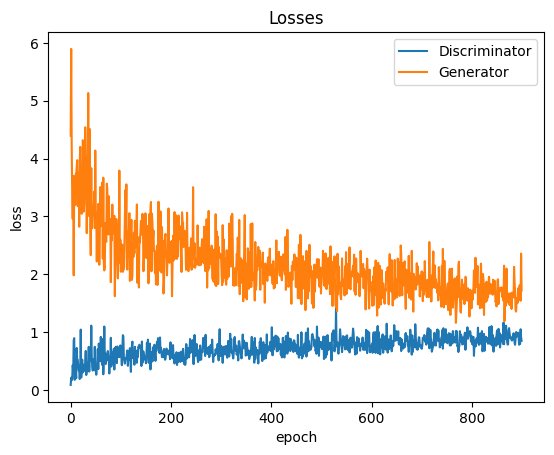

In [24]:
import matplotlib.pyplot as plt

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

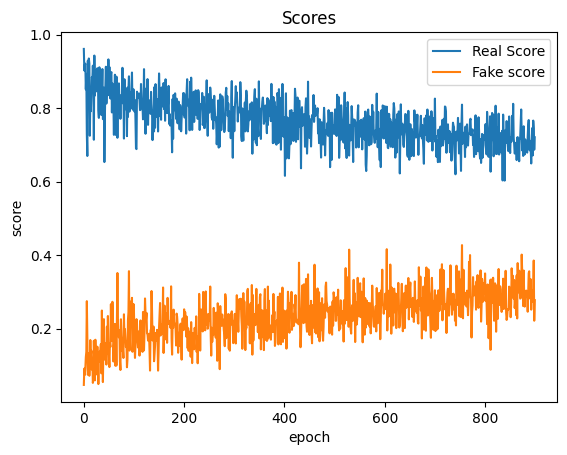

In [25]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

#### Evaluate Performance of GAN model (first 300 epochs)

In [26]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
GAN_real, GAN_fake, GAN_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 65.14%
Accuracy on fake images: 36.76%
Overall accuracy: 50.95%


### Step 3. Show 3+ samples created by GAN. Share lessons learned.

#### Show fake images after 10th, 50th, 100th and 300th epochs of training

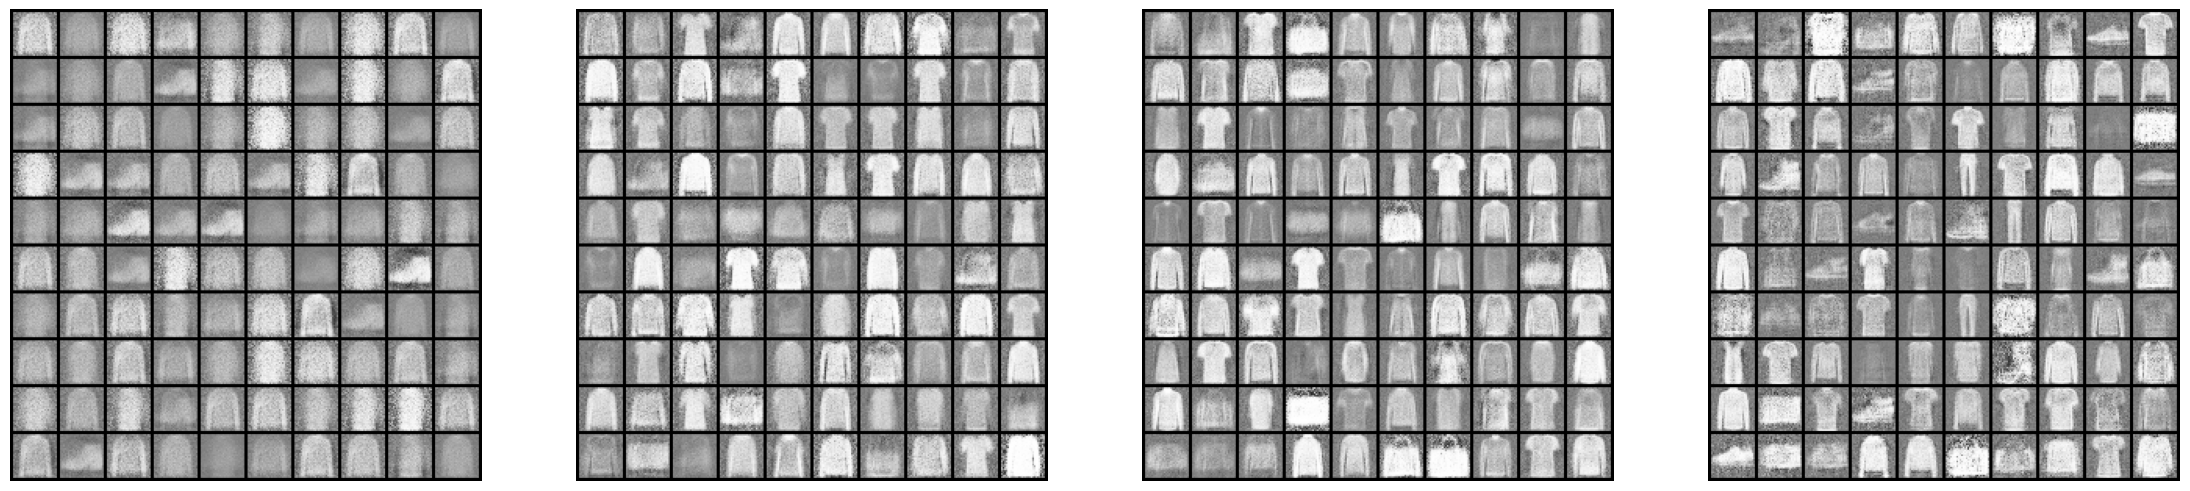

In [27]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/fake_images-0010.png',
    './sample_data/fake_images-0050.png',
    './sample_data/fake_images-0100.png',
    './sample_data/fake_images-0300.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

- Generation of image samples called individually yields usable results.
- Generator improves with practice.
- Gets close to real images.

#### Generate a time series video. <b>NOTE:</b> Images must be resized to match the dimensions of the video frames.

In [28]:
import cv2
import os
from IPython.display import FileLink

vid_fname  = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.mp4')

/content/gans_training.mp4

### Step 4. Save model weights with checkpoints

In [29]:
torch.save(G.state_dict(), 'generator_weights_checkpoints.ckpt')
torch.save(D.state_dict(), 'discriminator_weights_checkpoints.ckpt')

### Step 5. Load model

In [30]:
# Load checkpoint models for generator and discriminator
generator_checkpoint_path     = 'generator_weights_checkpoints.ckpt'
discriminator_checkpoint_path = 'discriminator_weights_checkpoints.ckpt'

# Load weights into the models
G.load_state_dict(torch.load(generator_checkpoint_path))
D.load_state_dict(torch.load(discriminator_checkpoint_path))

<All keys matched successfully>

In [31]:
# Set models to evaluation mode
G.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [32]:
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### Step 6. Re-train GAN (100 epochs)

Saving transf_fake_images-0000.png


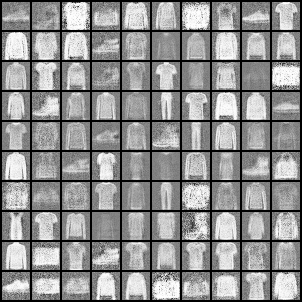

In [33]:
def save_transf_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'transf_fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_transf_fake_images(0)
Image(os.path.join(sample_dir, 'transf_fake_images-0000.png'))

In [34]:
%%time

num_epochs = 100
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_transf_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.8590, g_loss: 1.7160, D(x): 0.68, D(G(z)): 0.23
Epoch [0/100], Step [400/600], d_loss: 0.8768, g_loss: 1.4377, D(x): 0.77, D(G(z)): 0.34
Epoch [0/100], Step [600/600], d_loss: 0.9805, g_loss: 1.4882, D(x): 0.64, D(G(z)): 0.25
Saving transf_fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.9452, g_loss: 1.2370, D(x): 0.73, D(G(z)): 0.34
Epoch [1/100], Step [400/600], d_loss: 0.9002, g_loss: 1.7187, D(x): 0.63, D(G(z)): 0.22
Epoch [1/100], Step [600/600], d_loss: 0.7542, g_loss: 1.4563, D(x): 0.79, D(G(z)): 0.31
Saving transf_fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.0868, g_loss: 1.3415, D(x): 0.72, D(G(z)): 0.43
Epoch [2/100], Step [400/600], d_loss: 0.9292, g_loss: 1.7201, D(x): 0.69, D(G(z)): 0.31
Epoch [2/100], Step [600/600], d_loss: 0.8240, g_loss: 1.6917, D(x): 0.73, D(G(z)): 0.28
Saving transf_fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.9090, g_loss: 1.5493, D(x): 0.69, D(G(z)): 0.28
Epoch

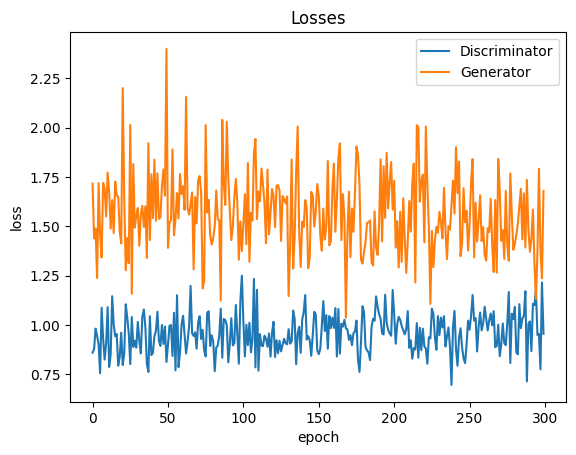

In [35]:
import matplotlib.pyplot as plt

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

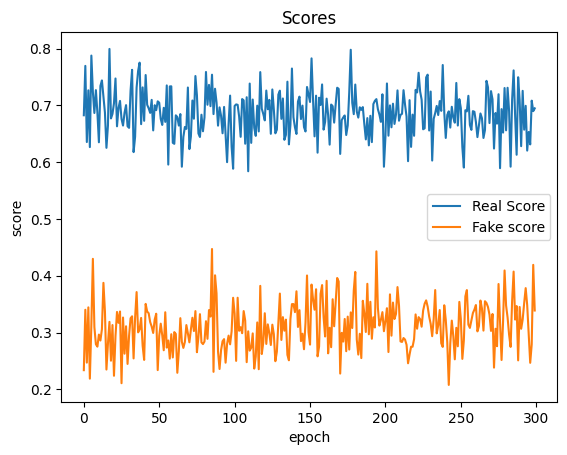

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

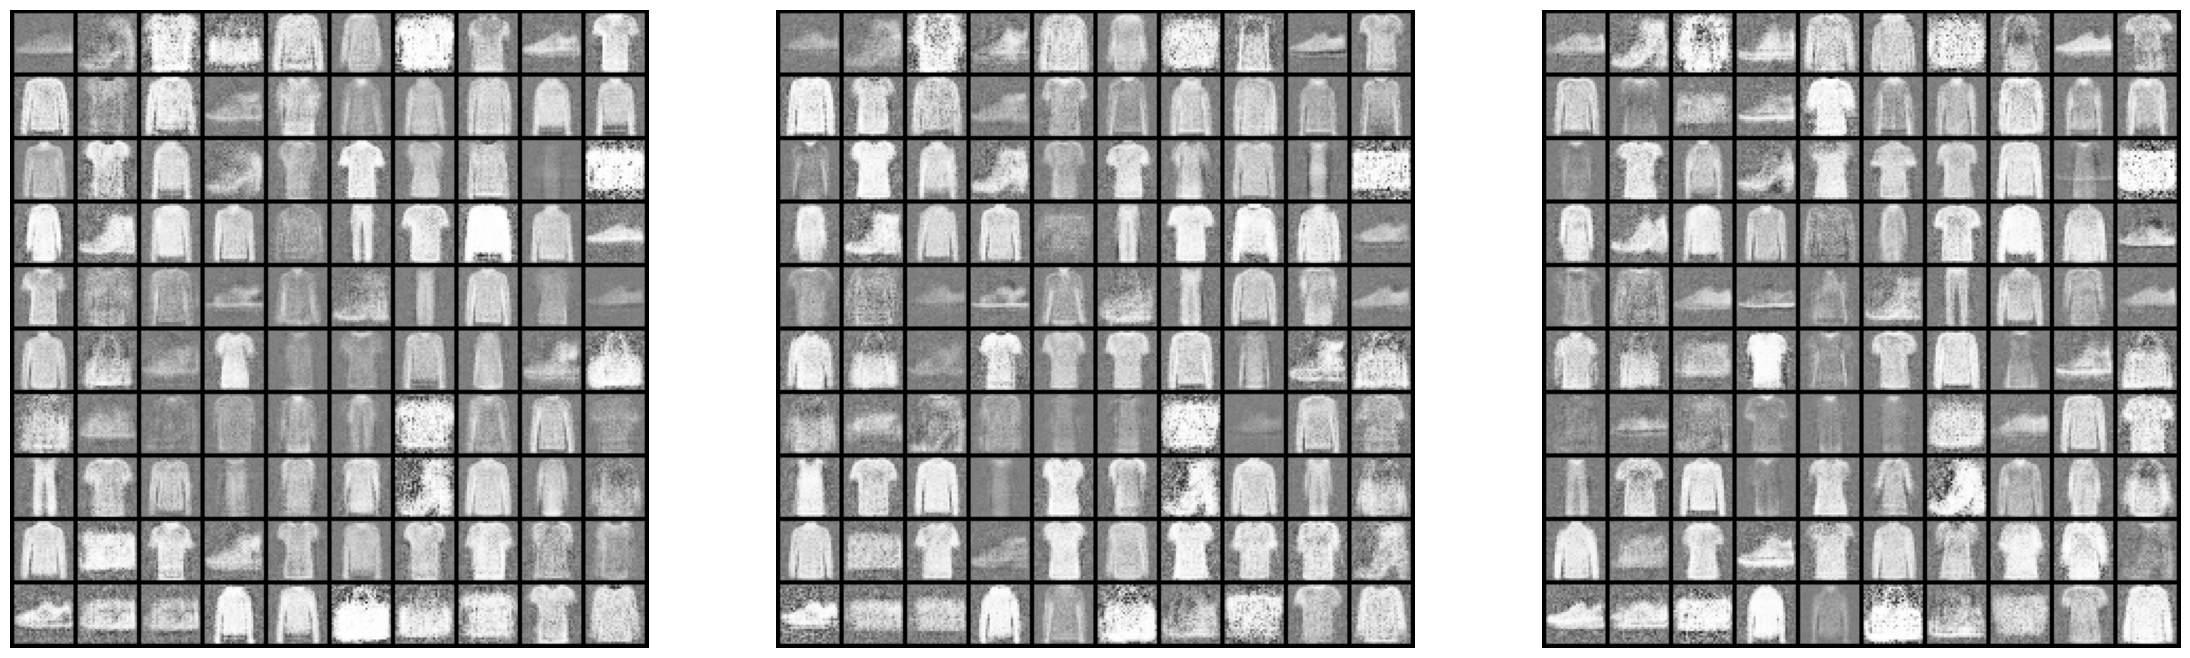

In [37]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/transf_fake_images-0010.png',
    './sample_data/transf_fake_images-0050.png',
    './sample_data/transf_fake_images-0100.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#### Evaluate Performance of tranfer learned model

In [38]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
trans_real, trans_fake, trans_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 69.58%
Accuracy on fake images: 29.14%
Overall accuracy: 49.36%


### Step 7. Save w/o checkpoints

In [39]:
torch.save(G.state_dict(), 'generator_weights_wo_checkpoints.pth')
torch.save(D.state_dict(), 'discriminator_weights_wo_checkpoints.pth')

### Step 8. Load w/o checkpoints

In [40]:
# Load checkpoint models for generator and discriminator
generator_checkpoint_path     = 'generator_weights_wo_checkpoints.pth'
discriminator_checkpoint_path = 'discriminator_weights_wo_checkpoints.pth'

# Load weights into the models
G.load_state_dict(torch.load(generator_checkpoint_path))
D.load_state_dict(torch.load(discriminator_checkpoint_path))

<All keys matched successfully>

In [41]:
G

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [42]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Part 2 -  LSGAN

Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

#### Reinitialize the model

In [43]:
G.to(device);
D.to(device);

In [44]:
# For LSGAN
criterion = nn.MSELoss()

Saving fake_LSGAN_images-0000.png


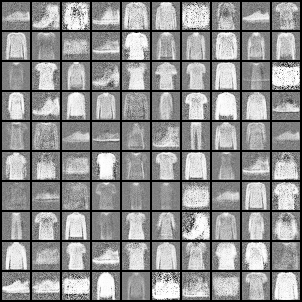

In [45]:
def save_fake_LSGAN_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_LSGAN_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_LSGAN_images(0)
Image(os.path.join(sample_dir, 'fake_LSGAN_images-0000.png'))

In [46]:
%%time

num_epochs = 300
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_LSGAN_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.2916, g_loss: 0.4707, D(x): 0.67, D(G(z)): 0.29
Epoch [0/300], Step [400/600], d_loss: 0.3390, g_loss: 0.4438, D(x): 0.67, D(G(z)): 0.34
Epoch [0/300], Step [600/600], d_loss: 0.3594, g_loss: 0.4308, D(x): 0.68, D(G(z)): 0.40
Saving fake_LSGAN_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3522, g_loss: 0.4785, D(x): 0.60, D(G(z)): 0.31
Epoch [1/300], Step [400/600], d_loss: 0.3391, g_loss: 0.4873, D(x): 0.63, D(G(z)): 0.33
Epoch [1/300], Step [600/600], d_loss: 0.3226, g_loss: 0.4723, D(x): 0.68, D(G(z)): 0.35
Saving fake_LSGAN_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3069, g_loss: 0.5126, D(x): 0.68, D(G(z)): 0.33
Epoch [2/300], Step [400/600], d_loss: 0.3463, g_loss: 0.4484, D(x): 0.63, D(G(z)): 0.32
Epoch [2/300], Step [600/600], d_loss: 0.3105, g_loss: 0.4649, D(x): 0.69, D(G(z)): 0.35
Saving fake_LSGAN_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3183, g_loss: 0.4576, D(x): 0.65, D(G(z)): 0.32
Epoch [3

#### Evaluate Performance of LSGAN model (300 epochs)

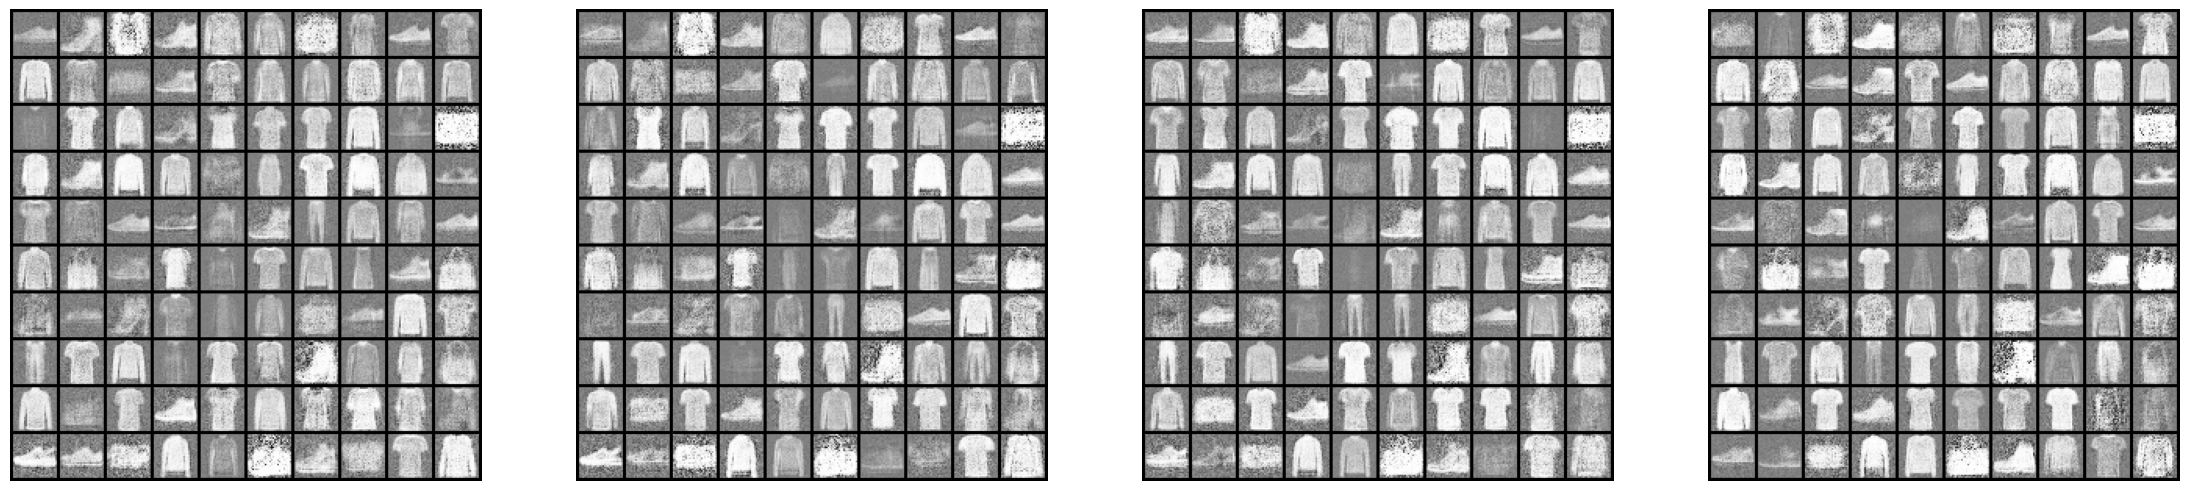

In [48]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/fake_LSGAN_images-0010.png',
    './sample_data/fake_LSGAN_images-0050.png',
    './sample_data/fake_LSGAN_images-0100.png',
    './sample_data/fake_LSGAN_images-0300.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [49]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
LSGAN_real, LSGAN_fake, LSGAN_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 66.14%
Accuracy on fake images: 33.00%
Overall accuracy: 49.57%


In [52]:
print('Accuracy of Models')
print(f'GAN:        Real {GAN_real} | Fake {GAN_fake} | Overall {GAN_overall}')
print(f'Transf GAN: Real {trans_real} | Fake {trans_fake} | Overall {trans_overall}')
print(f'LSGN:       Real {LSGAN_real} | Fake {LSGAN_fake}  | Overall {LSGAN_overall}')

Accuracy of Models
GAN:        Real 65.14 | Fake 36.76 | Overall 50.95
Transf GAN: Real 69.58 | Fake 29.14 | Overall 49.36
LSGN:       Real 66.14 | Fake 33.0  | Overall 49.57
